# TechNova Partners

**Sommaire :**
1. Chargement des données 
2. Diagnostic du déséquilibre
3. EDA (numérique & catégorielle) + tests statistiques
4. Pairplot (matrice de dispersion) pour corrélations & multicolinéarité
5. 1ʳᵉ itération : petit modèle (4 variables, 10% des lignes), matrice de confusion
6. 2ᵉ itération : équilibrage (oversampling simple / `class_weight`), features, CV
7. Interprétation globale & locale (importance des features, SHAP)

## 0) Imports & configuration

In [1]:
# === Imports & configuration ===
import warnings
import shap
import warnings
import os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV, learning_curve
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, f1_score, recall_score, precision_score, 
    roc_auc_score, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.base import clone  # si besoin
from manet_projet04 import load_settings,shap_global, shap_local
from brand.brand import Theme, load_brand

# Application du thème OpenClassrooms pour uniformiser les prochains graphiques
cfg = load_brand("brand/brand.yml")
Theme.apply()
cmap_heatmap = Theme.colormap("diverging", start="primary", end="secondary")


HAS_SHAP = True
HAS_IMBLEARN = True
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/Users/steph/Code/Python/Jupyter/projet_04/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Paramètres & chemins

In [2]:
CFG = load_settings('manet_projet04/settings.yml')

RANDOM_STATE = CFG["RANDOM_STATE"]
PATH_SIRH    = CFG["PATH_SIRH"]
PATH_EVAL    = CFG["PATH_EVAL"]
PATH_SONDAGE = CFG["PATH_SONDAGE"]
COL_ID       = CFG["COL_ID"]
TARGET       = CFG["TARGET"]
NUM_COLS     = CFG["NUM_COLS"]
CAT_COLS     = CFG["CAT_COLS"]
SAT_COLS     = CFG["SAT_COLS"]
FIRST_VARS   = CFG["FIRST_VARS"]
SUBSAMPLE_FRAC = CFG["SUBSAMPLE_FRAC"]
SQL_FILE = "merge_sql.sql"
DB_FILE = "merge_temp.db"

## 2) Chargement, contrôles et assemblage

In [3]:
# --- Config ---
DB_FILE = "merge_temp.db"
SQL_FILE = "merge_sql.sql"
COL_ID = "id_employee"

# --- Fonctions utilitaires ---
def safe_read_csv(path):
    """Lecture sécurisée d’un CSV."""
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"[ATTENTION] Lecture impossible {path}: {e}")
        return pd.DataFrame()

def clean_text_values(df):
    """Nettoie les valeurs texte incohérentes ou équivalentes à NaN."""
    df = df.copy()
    to_replace = [
        '', ' ', '  ', '   ', 'nan', 'NaN', 'NAN', 'None',
        'JE ne sais pas', 'je ne sais pas', 'Je ne sais pas',
        'Unknow', 'Unknown', 'non pertinent', 'Non pertinent', 'NON PERTINENT'
    ]
    df = df.replace(to_replace, np.nan)
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].replace(to_replace, np.nan).str.strip()
    return df

# --- Lecture des fichiers ---
sirh = safe_read_csv(PATH_SIRH)
evaluation = safe_read_csv(PATH_EVAL)
sond  = safe_read_csv(PATH_SONDAGE)

print("Tailles initiales :", len(sirh), len(evaluation), len(sond))

# --- Harmonisation des clés ---
if 'id_employee' in sirh.columns:
    sirh['id_employee'] = sirh['id_employee'].astype(str).str.extract(r'(\d+)').astype(int)

if 'eval_number' in evaluation.columns:
    evaluation['eval_number'] = evaluation['eval_number'].astype(str).str.replace(r'[^0-9]', '', regex=True)
    evaluation['eval_number'] = evaluation['eval_number'].astype(int)
    evaluation.rename(columns={'eval_number': 'id_employee'}, inplace=True)

if 'code_sondage' in sond.columns:
    sond['code_sondage'] = sond['code_sondage'].astype(str).str.replace(r'[^0-9]', '', regex=True)
    sond['code_sondage'] = sond['code_sondage'].astype(int)
    sond.rename(columns={'code_sondage': 'id_employee'}, inplace=True)

# --- Nettoyage des valeurs texte ---
sirh = clean_text_values(sirh)
evaluation = clean_text_values(evaluation)
sond  = clean_text_values(sond)

# --- Vérifications ---
print("\n=== Vérification des clés id_employee avant fusion ===")

for name, df_ in [('sirh', sirh), ('evaluation', evaluation), ('sond', sond)]:
    total = len(df_)
    uniques = df_['id_employee'].nunique(dropna=True)
    doublons = total - uniques

    print(f"{name:>6} : {total:5d} lignes | {uniques:5d} identifiants uniques | {doublons:4d} doublons")

    # Liste les ID en doublon si nécessaire
    if doublons > 0:
        dup_ids = (
            df_['id_employee']
            .value_counts()
            .loc[lambda x: x > 1]
            .index.tolist()
        )
        print(f"  ⚠️  Attention : {len(dup_ids)} doublons détectés dans {name} → ex: {dup_ids[:5]}")

if 'id_employee' not in sirh.columns:
    raise ValueError("La clé 'id_employee' doit exister dans SIRH après harmonisation.")

# --- Merge via SQL (traçable et sécurisé) ---
if os.path.exists(DB_FILE):
    os.remove(DB_FILE)
conn = sqlite3.connect(DB_FILE)

sirh.to_sql("sirh", conn, index=False)
evaluation.to_sql("evaluation", conn, index=False)
sond.to_sql("sond", conn, index=False)

sql_query = f"""
SELECT *
FROM sirh
INNER JOIN evaluation USING ({COL_ID})
INNER JOIN sond USING ({COL_ID});
"""

with open(SQL_FILE, "w", encoding="utf-8") as f:
    f.write(sql_query)

df = pd.read_sql_query(sql_query, conn)
conn.close()

print(f"Merge réussi — shape finale : {df.shape}")
print("Aperçu des identifiants :", df['id_employee'].head().tolist())
df.head(3)


Tailles initiales : 1470 1470 1470

=== Vérification des clés id_employee avant fusion ===
  sirh :  1470 lignes |  1470 identifiants uniques |    0 doublons
evaluation :  1470 lignes |  1470 identifiants uniques |    0 doublons
  sond :  1470 lignes |  1470 identifiants uniques |    0 doublons
Merge réussi — shape finale : (1470, 32)
Aperçu des identifiants : [1, 2, 4, 5, 7]


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,0,3,1,2,2,Autre,Y,Occasionnel,0,0


## 3) Déséquilibre de la cible

Effectifs par classe:
 a_quitte_l_entreprise
0    1233
1     237
Name: count, dtype: int64

Répartition (%):
 a_quitte_l_entreprise
0    83.88
1    16.12
Name: count, dtype: float64


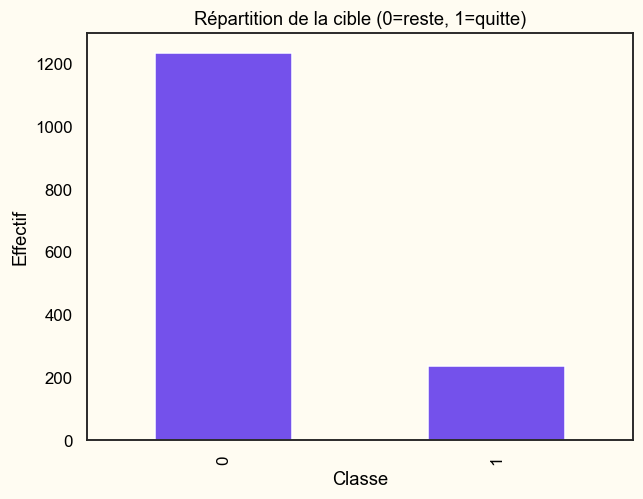

In [4]:
# === Diagnostic du déséquilibre de la cible (version robuste) ===
if TARGET not in df.columns:
    raise ValueError(f"Cible {TARGET} absente. Assurez-vous qu'elle est dans le fichier sondage.")

# Normalisation des valeurs de la cible (convertit oui/non, True/False, etc.)
df[TARGET] = df[TARGET].astype(str).str.strip().str.lower().map({
    '1': 1, '0': 0,
    'oui': 1, 'non': 0,
    'True': 1, 'False': 0,
    'quitte': 1, 'reste': 0
})

# Suppression des valeurs non mappées
df = df[df[TARGET].isin([0, 1])].copy()

# Vérification du contenu
if df.empty or df[TARGET].nunique() < 2:
    raise ValueError(f"La variable cible {TARGET} ne contient pas de valeurs valides (0/1) après nettoyage.")

# Comptage et affichage
counts = df[TARGET].value_counts().sort_index()
ratio = (counts / counts.sum() * 100).round(2)
print('Effectifs par classe:\n', counts)
print('\nRépartition (%):\n', ratio)

# Bar plot sécurisé
if counts.empty:
    print("[INFO] Aucun effectif valide à afficher pour la cible.")
else:
    plt.figure()
    counts.plot(kind='bar')
    plt.title('Répartition de la cible (0=reste, 1=quitte)')
    plt.xlabel('Classe')
    plt.ylabel('Effectif')
    plt.show()

## 4) EDA 

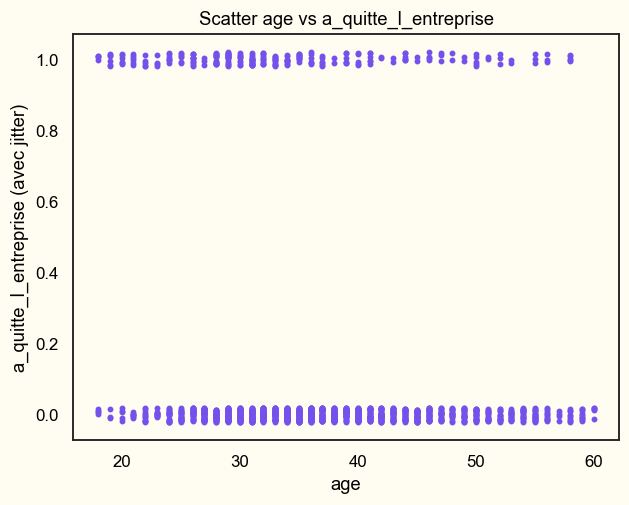

/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_40907/637780893.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['reste(0)','quitte(1)'])


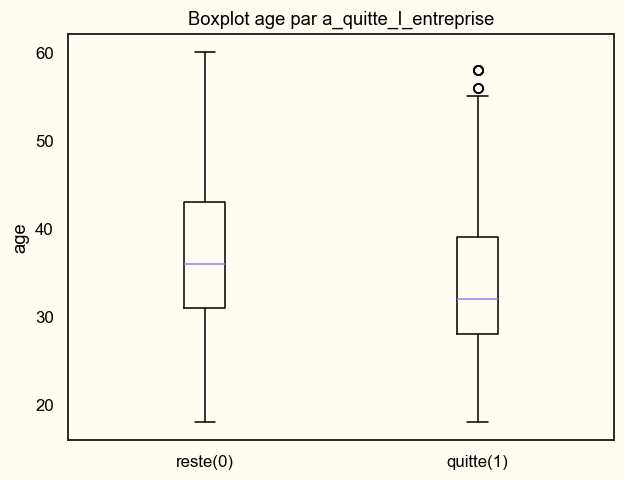

Test Mann-Whitney U sur 'age' → stat=185362.000, p=5.3e-11


In [5]:
# === EDA – Numérique : exemples de graphiques et tests ===
import scipy.stats as stats

def scatter_by_target(df, xcol, target=TARGET):
    # Scatter jitter simple sur l'axe Y pour distinguer les classes
    y = df[target].values + np.random.uniform(-0.02, 0.02, size=len(df))
    plt.figure()
    plt.scatter(df[xcol], y, s=8)
    plt.xlabel(xcol)
    plt.ylabel(target + ' (avec jitter)')
    plt.title(f'Scatter {xcol} vs {target}')
    plt.show()

def box_by_target(df, xcol, target=TARGET):
    # Boxplot via pandas/matplotlib (split par classe)
    plt.figure()
    data0 = df[df[target]==0][xcol].dropna()
    data1 = df[df[target]==1][xcol].dropna()
    plt.boxplot([data0, data1], labels=['reste(0)','quitte(1)'])
    plt.title(f'Boxplot {xcol} par {target}')
    plt.ylabel(xcol)
    plt.show()
    return data0, data1

def numeric_tests(data0, data1):
    # Normalité → Shapiro (sur échantillons <= 5000 pour éviter erreurs)
    d0 = data0.sample(min(len(data0), 5000), random_state=RANDOM_STATE)
    d1 = data1.sample(min(len(data1), 5000), random_state=RANDOM_STATE)
    try:
        p0 = stats.shapiro(d0).pvalue
        p1 = stats.shapiro(d1).pvalue
    except Exception:
        p0 = p1 = 0.0

    normal = (p0>0.05) and (p1>0.05)
    if normal:
        stat, p = stats.ttest_ind(d0, d1, equal_var=False)
        test_name = 't-test (Welch)'
    else:
        stat, p = stats.mannwhitneyu(d0, d1, alternative='two-sided')
        test_name = 'Mann-Whitney U'
    return test_name, stat, p

# Exemple: Age
if 'age' in df.columns:
    scatter_by_target(df.dropna(subset=['age', TARGET]), 'age', TARGET)
    d0, d1 = box_by_target(df, 'age', TARGET)
    tn, st, p = numeric_tests(d0, d1)
    print(f"Test {tn} sur 'age' → stat={st:.3f}, p={p:.3g}")
else:
    print("[INFO] Colonne 'age' absente – passe l'exemple ou adapte les noms.")

## 5) EDA Catégorielle

Dans le code qui suit on cherche à vérifier s'il existe une relation entre les variables qualitatives.

On fait l'hypothèse qu'il existe une relation de dépendance entre a_quitte_l_entreprise et
+ genre (on rejète h)
+ le statut marital (on ne rejète pas h)
+ le département (on ne rejète pas)
+ les enfants (on rejète)


H non rejeté :
* Très forte corrélation
    * poste, niveau_hierarchique_poste, statut_marital
* Corrélation Moyenne (<0.05 mais proche)
    * frequence_deplacement, departement, domaine_etude

H rejeté :
niveau_education, genre, ayant_enfant

In [6]:
# === EDA – Catégorielle : tableaux croisés + Chi2 ===
from itertools import islice

def chi2_for_categorical(df, col, target=TARGET):
    ct = pd.crosstab(df[col], df[target])
    from scipy.stats import chi2_contingency
    chi2, p, dof, exp = chi2_contingency(ct)
    return ct, chi2, p, dof

for col in CAT_COLS:
    if col in df.columns:
        ct, chi2, p, dof = chi2_for_categorical(df.dropna(subset=[col, TARGET]), col, TARGET)
        print(f"\n[Cat: {col}]\n", ct.head())
        print(f"Chi²={chi2:.3f}, dof={dof}, p={p:.3g}")
    else:
        print(f"[INFO] Catégorie '{col}' absente – adapte CAT_COLS.")


[Cat: genre]
 a_quitte_l_entreprise    0    1
genre                          
F                      501   87
M                      732  150
Chi²=1.117, dof=1, p=0.291

[Cat: statut_marital]
 a_quitte_l_entreprise    0    1
statut_marital                 
Célibataire            350  120
Divorcé(e)             294   33
Marié(e)               589   84
Chi²=46.164, dof=2, p=9.46e-11

[Cat: departement]
 a_quitte_l_entreprise    0    1
departement                    
Commercial             354   92
Consulting             828  133
Ressources Humaines     51   12
Chi²=10.796, dof=2, p=0.00453

[Cat: poste]
 a_quitte_l_entreprise     0   1
poste                          
Assistant de Direction  245  47
Cadre Commercial        269  57
Consultant              197  62
Directeur Technique      78   2
Manager                 122   9
Chi²=86.190, dof=8, p=2.75e-15

[Cat: niveau_hierarchique_poste]
 a_quitte_l_entreprise        0    1
niveau_hierarchique_poste          
1                          

## 6) Matrice de dispersion

In [7]:
# === Nettoyage des colonnes numériques pour conversion en float ===
import re

def to_float_clean(val):
    """Convertit proprement les valeurs avec % , € , , etc. en float."""
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    # Nettoyage des caractères non numériques (garde . et , et -)
    val = str(val).strip().replace(',', '.')
    # Supprime tout sauf chiffres, ., - 
    val = re.sub(r'[^0-9\.\-]', '', val)
    try:
        return float(val)
    except ValueError:
        return np.nan

for col in NUM_COLS:
    if col in df.columns:
        # si colonne de type objet => tentative de conversion
        if df[col].dtype == 'object':
            df[col] = df[col].apply(to_float_clean)

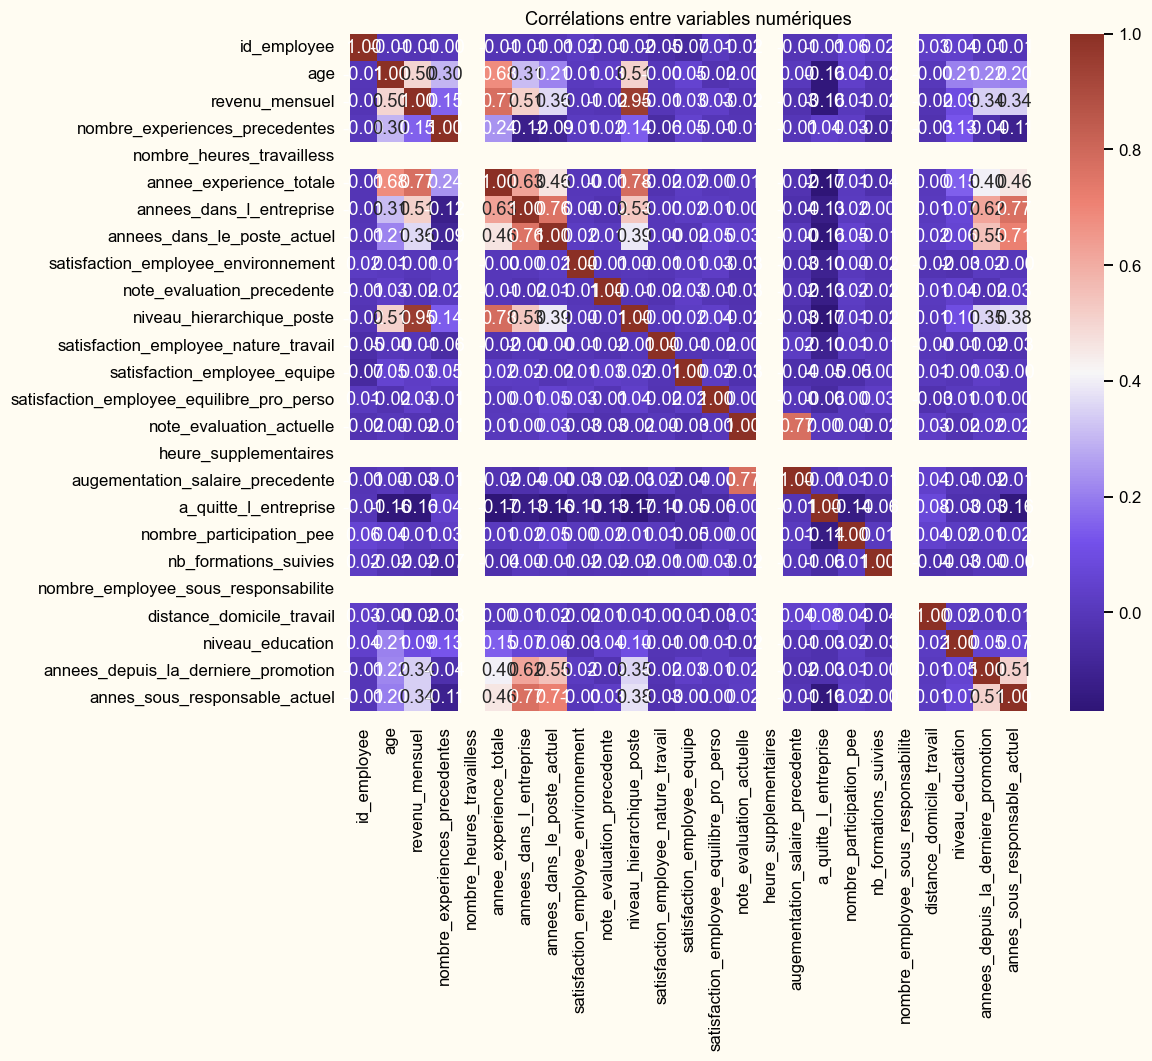

In [8]:
# === Heatmap de corrélation des variables numériques ===
num_cols = df.select_dtypes(include='number').columns
corr = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap=cmap_heatmap, annot=True, fmt=".2f", square=True)
plt.title("Corrélations entre variables numériques")
plt.show()


## 7) Feature engineering

In [9]:
# === Mise à jour de la base SQL avec les nouvelles features ===

# 1️⃣ Vérification du fichier DB existant
if not os.path.exists(DB_FILE):
    raise FileNotFoundError(f"Base SQLite '{DB_FILE}' introuvable. Relance le merge avant d'y insérer les nouvelles features.")

# 2️⃣ Connexion à la base SQLite
conn = sqlite3.connect(DB_FILE)

# 3️⃣ Sauvegarde du DataFrame complet (fusion + features)
# On écrase la table existante "df_final" si elle existe déjà
TABLE_NAME = "df_final"

df.to_sql(TABLE_NAME, conn, index=False, if_exists='replace')

# 4️⃣ Validation et fermeture
conn.commit()
conn.close()

print(f"Table '{TABLE_NAME}' mise à jour dans '{DB_FILE}' ({len(df)} lignes, {len(df.columns)} colonnes).")

# --- Vérification rapide ---
TABLE_NAME = globals().get("TABLE_NAME", "df_final")  # Défaut si non défini
conn = sqlite3.connect(DB_FILE)
check = pd.read_sql_query(f"PRAGMA table_info({TABLE_NAME});", conn)
print("Colonnes présentes dans la table SQL :")
display(check[['name']])
conn.close()

# === Nettoyage et conversion de la variable cible ===
if TARGET in df.columns:
    df[TARGET] = (
        df[TARGET]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({
            'oui': 1, 'o': 1, 'true': 1, '1': 1,
            'non': 0, 'n': 0, 'false': 0, '0': 0
        })
    )

    # Force le type int si possible
    df[TARGET] = pd.to_numeric(df[TARGET], errors='coerce')
    df = df[df[TARGET].isin([0,1])].copy()
else:
    raise ValueError(f"La colonne cible '{TARGET}' est absente du dataframe.")


Table 'df_final' mise à jour dans 'merge_temp.db' (1470 lignes, 32 colonnes).
Colonnes présentes dans la table SQL :


,name
0,id_employee
1,age
2,genre
3,revenu_mensuel
4,statut_marital
5,departement
6,poste
7,nombre_experiences_precedentes
8,nombre_heures_travailless
9,annee_experience_totale


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_40907/2683554574.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


## 8) 1ʳᵉ itération – Modèle léger + matrice de confusion

[ATTENTION] Moins de 2 variables disponibles pour la 1ʳᵉ itération.


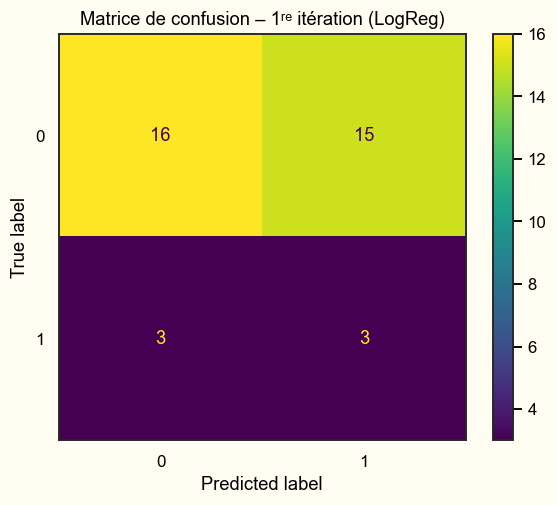

              precision    recall  f1-score   support

           0      0.842     0.516     0.640        31
           1      0.167     0.500     0.250         6

    accuracy                          0.514        37
   macro avg      0.504     0.508     0.445        37
weighted avg      0.733     0.514     0.577        37

ROC-AUC: 0.5483870967741935


In [10]:
# === 1ʳᵉ itération : 4 variables, 10% des lignes ===

first_vars = [c for c in ['age','salaire','anciennete','note_performance'] if c in df.columns]
if len(first_vars) < 2:
    print('[ATTENTION] Moins de 2 variables disponibles pour la 1ʳᵉ itération.')

df_sub = df.dropna(subset=first_vars + [TARGET]).copy()
if len(df_sub) > 0:
    df_sub = df_sub.sample(frac=min(SUBSAMPLE_FRAC, 1.0), random_state=RANDOM_STATE) if len(df_sub) > 100 else df_sub
    X = df_sub[first_vars]
    y = df_sub[TARGET].astype(int)

    num_pipe = ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preproc = ColumnTransformer([('num', num_pipe, first_vars)], remainder='drop')

    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
    pipe = ImbPipeline([('prep', preproc), ('clf', clf)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]

    # Matrice de confusion (métrique principale)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title('Matrice de confusion – 1ʳᵉ itération (LogReg)')
    plt.show()

    print(classification_report(y_test, y_pred, digits=3))
    print('ROC-AUC:', roc_auc_score(y_test, y_prob))
else:
    print('[ATTENTION] Pas assez de données nettoyées pour la 1ʳᵉ itération.')
    
# Sauvegarde de la requête SQL correspondante pour documentation
with open("update_features.sql", "w", encoding="utf-8") as f:
    f.write(f"-- Mise à jour des features dans {TABLE_NAME}\n")
    f.write(f"-- {len(df.columns)} colonnes et {len(df)} lignes au total\n")


## 9) 2ᵉ itération – Équilibrage + modèles + CV

Taille X_full: (1470, 37)
Répartition de la cible:
 a_quitte_l_entreprise
0    1233
1     237
Name: count, dtype: int64
Oversampling SMOTE effectué (classes équilibrées).

=== LogReg_balanced ===


/Users/steph/Code/Python/Jupyter/projet_04/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Meilleurs hyperparamètres : {'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Seuil optimal (max F1): 0.478


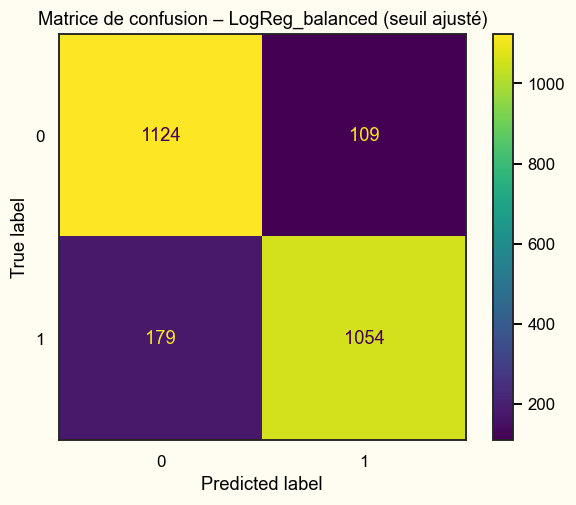

              precision    recall  f1-score   support

           0      0.863     0.912     0.886      1233
           1      0.906     0.855     0.880      1233

    accuracy                          0.883      2466
   macro avg      0.884     0.883     0.883      2466
weighted avg      0.884     0.883     0.883      2466



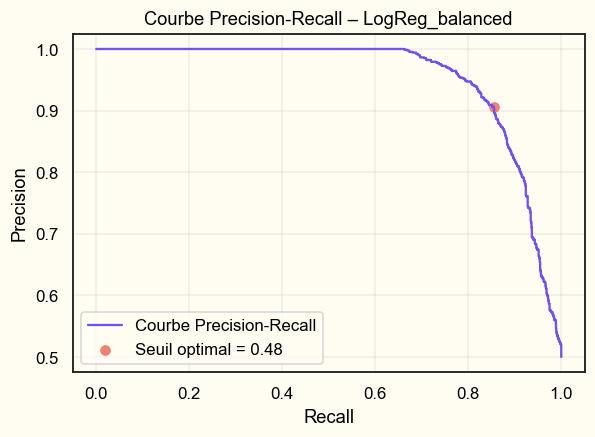


=== RF_balanced ===
Meilleurs hyperparamètres : {'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Seuil optimal (max F1): 0.547


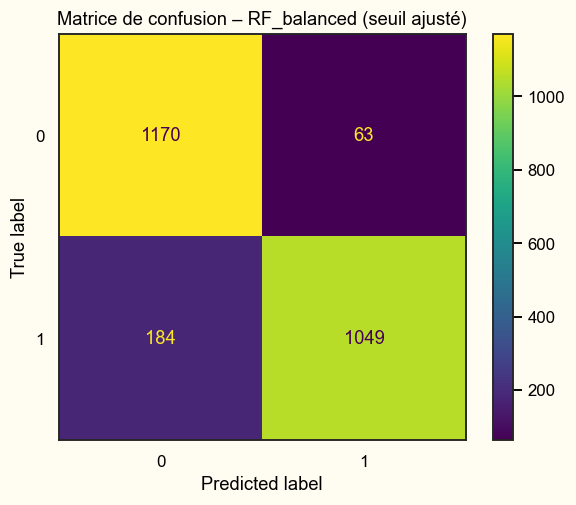

              precision    recall  f1-score   support

           0      0.864     0.949     0.905      1233
           1      0.943     0.851     0.895      1233

    accuracy                          0.900      2466
   macro avg      0.904     0.900     0.900      2466
weighted avg      0.904     0.900     0.900      2466



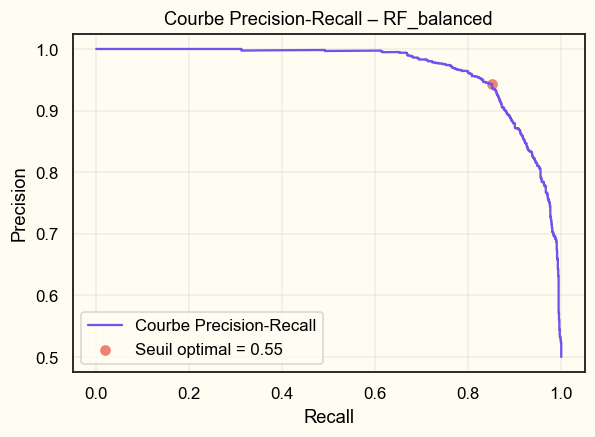


=== Résultats (seuil optimisé) ===


,model,best_params,best_threshold,F1,Recall,Precision,ROC_AUC
1,RF_balanced,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.546895,0.89467,0.850770,0.943345,0.962071
0,LogReg_balanced,"{'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__s...",0.477592,0.87980,0.854826,0.906277,0.937299


In [11]:
# === 2ᵉ itération : oversampling + cross-validation + ajustement de seuil ===

ALL_NUM = [c for c in NUM_COLS if c in df.columns]
ALL_CAT = [c for c in CAT_COLS if c in df.columns]

df2 = df.copy()
df2 = df2[df2[TARGET].isin([0, 1])].copy()

# --- Imputation des NaN sur les variables numériques ---
for col in ALL_NUM:
    if col in df2.columns:
        median_val = df2[col].median()
        df2[col] = df2[col].fillna(median_val)

# --- Encodage des variables catégorielles ---
X_num = df2[ALL_NUM] if ALL_NUM else pd.DataFrame(index=df2.index)
X_cat = pd.get_dummies(df2[ALL_CAT], drop_first=True) if ALL_CAT else pd.DataFrame(index=df2.index)
X_full = pd.concat([X_num, X_cat], axis=1)

# Sécurité : forcer tout en numérique et remplacer les résidus NaN
X_full = X_full.apply(pd.to_numeric, errors='coerce').fillna(0)
y_full = df2[TARGET].astype(int)
X_raw = X_full.copy()
y_raw = y_full.copy()


print("Taille X_full:", X_full.shape)
print("Répartition de la cible:\n", y_full.value_counts())

# Vérification de la diversité des classes
if y_full.nunique() < 2:
    raise ValueError("[ERREUR] La variable cible n'a qu'une seule classe présente après nettoyage.")

# --- Oversampling global avant cross-validation ---
try:
    sm = SMOTE(random_state=RANDOM_STATE)
    X_full, y_full = sm.fit_resample(X_full, y_full)
    print("Oversampling SMOTE effectué (classes équilibrées).")
except ValueError as e:
    print(f"[ATTENTION] SMOTE impossible : {e}\n→ utilisation de simple oversample() à la place.")
    X_full, y_full = simple_oversample(X_full, y_full)

# --- Prétraitement pour les modèles ---
num_pipe2 = ImbPipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])
preproc2 = ColumnTransformer([('num', num_pipe2, list(X_num.columns))], remainder='passthrough')

# --- Modèles ---
models = {
    'LogReg_balanced': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    'RF_balanced': RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE
    )
}

param_grids = {
    'LogReg_balanced': [
        {
            'clf__solver': ['lbfgs'],
            'clf__penalty': ['l2'],
            'clf__C': [0.1, 1.0, 10.0]
        },
        {
            'clf__solver': ['liblinear'],
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [0.1, 1.0, 10.0]
        }
    ],
    'RF_balanced': {
        'clf__n_estimators': [200, 300, 500],
        'clf__max_depth': [6, 8, 10],
        'clf__min_samples_split': [5, 10, 15],
        'clf__min_samples_leaf': [2, 5, 8]
    }
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

for name, base_model in models.items():
    print(f"\n=== {name} ===")

    pipe = ImbPipeline([
        ('prep', preproc2),
        ('clf', base_model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )
    grid.fit(X_full, y_full)

    print("Meilleurs hyperparamètres :", grid.best_params_)
    best_pipe = grid.best_estimator_

    # Cross-validation avec prédictions de probabilité
    y_proba_cv = cross_val_predict(best_pipe, X_full, y_full, cv=cv, method='predict_proba')[:, 1]

    # --- Ajustement du seuil optimal (max F1) ---
    precision, recall, thresholds = precision_recall_curve(y_full, y_proba_cv)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    print(f"Seuil optimal (max F1): {best_threshold:.3f}")
    y_pred_opt = (y_proba_cv >= best_threshold).astype(int)

    # --- Évaluation finale ---
    cm = confusion_matrix(y_full, y_pred_opt)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Matrice de confusion – {name} (seuil ajusté)")
    plt.show()

    print(classification_report(y_full, y_pred_opt, digits=3))

    # --- Courbe Precision-Recall ---
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color=Theme.PRIMARY, label='Courbe Precision-Recall')
    plt.scatter(recall[best_idx], precision[best_idx], color=Theme.SECONDARY, label=f'Seuil optimal = {best_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Courbe Precision-Recall – {name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'best_threshold': best_threshold,
        'F1': f1_score(y_full, y_pred_opt),
        'Recall': recall_score(y_full, y_pred_opt),
        'Precision': precision_score(y_full, y_pred_opt),
        'ROC_AUC': roc_auc_score(y_full, y_proba_cv)
    })

# --- Résumé des performances ---
res_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\n=== Résultats (seuil optimisé) ===")
display(res_df)
best_row = res_df.iloc[0]
best_model_name = best_row['model']
best_params = best_row.get('best_params', {}) or {}


Taille du jeu utilisé pour la courbe : (2466, 37) – équilibré (après SMOTE global)
Répartition cible dans ce jeu:
a_quitte_l_entreprise
1    1233
0    1233
Name: count, dtype: int64
Seuil F1 utilisé : 0.547


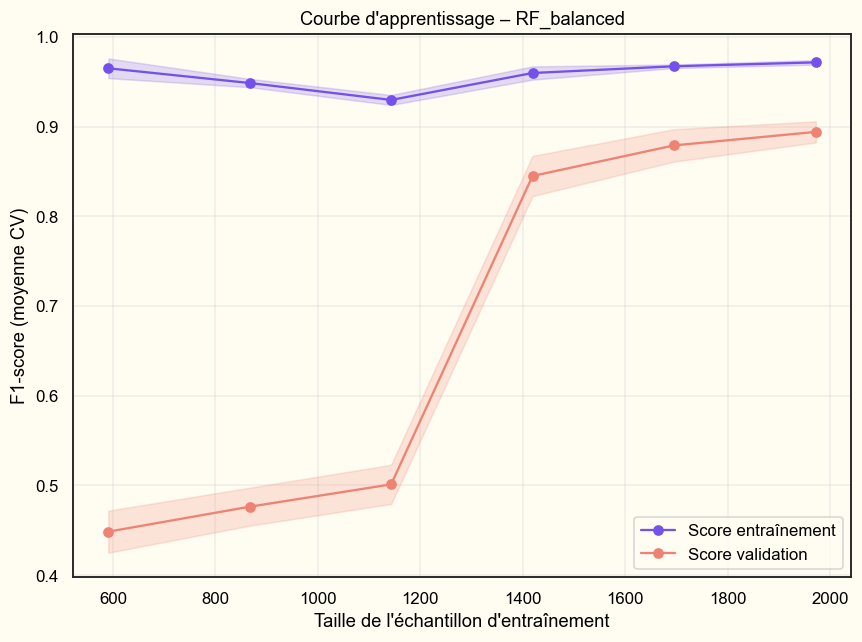

In [12]:
# === Courbe d'apprentissage (jeu original, SMOTE uniquement en CV) ===

import ast
from sklearn.metrics import f1_score

res_df_final = res_df.copy()
model_name = best_model_name
row = res_df_final[res_df_final['model'] == model_name]

if row.empty:
    print(f"[INFO] Modèle {model_name} absent des résultats, courbe non tracée.")
else:
    best_params = row.iloc[0].get('best_params', {}) or {}
    best_threshold = float(row.iloc[0].get('best_threshold', 0.5) or 0.5)
    if isinstance(best_params, str):
        try:
            best_params = ast.literal_eval(best_params)
        except (ValueError, SyntaxError):
            best_params = {}

    use_original_learning = False  # True pour observer le comportement sans oversampling global
    if use_original_learning:
        X_learning = globals().get('X_raw', X_full)
        y_learning = globals().get('y_raw', y_full)
    else:
        X_learning = X_full
        y_learning = y_full

    dataset_label = "original (avant SMOTE)" if use_original_learning else "équilibré (après SMOTE global)"
    print(f"Taille du jeu utilisé pour la courbe : {X_learning.shape} – {dataset_label}")
    print("Répartition cible dans ce jeu:")
    print(y_learning.value_counts())
    print(f"Seuil F1 utilisé : {best_threshold:.3f}")

    if model_name == 'LogReg_balanced':
        base_model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)
    elif model_name == 'RF_balanced':
        base_model = RandomForestClassifier(
            n_estimators=300,
            max_depth=8,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight='balanced_subsample',
            random_state=RANDOM_STATE
        )
    else:
        print(f"[INFO] Modèle {model_name} non géré pour la courbe d'apprentissage.")
        base_model = None

    if base_model is not None:
        clf_params = {k.split('__', 1)[1]: v for k, v in best_params.items() if k.startswith('clf__')}
        if clf_params:
            base_model.set_params(**clf_params)

        if model_name == 'LogReg_balanced':
            base_model.set_params(max_iter=max(base_model.get_params().get('max_iter', 1000), 2000))

        steps = []
        if use_original_learning:
            steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
        steps.extend([
            ('prep', preproc2),
            ('clf', base_model)
        ])
        model_pipe = ImbPipeline(steps)

        def f1_with_threshold(estimator, X, y):
            proba = estimator.predict_proba(X)[:, 1]
            y_pred = (proba >= best_threshold).astype(int)
            return f1_score(y, y_pred)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        train_sizes_grid = np.linspace(0.3, 1.0, 6)

        train_sizes, train_scores, test_scores = learning_curve(
            model_pipe,
            X_learning,
            y_learning,
            cv=cv,
            scoring=f1_with_threshold,
            n_jobs=-1,
            train_sizes=train_sizes_grid
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        fig, ax = plt.subplots(figsize=(8, 6), facecolor=Theme.BACKGROUND)
        ax.set_facecolor(Theme.BACKGROUND)
        ax.plot(train_sizes, train_mean, "o-", label="Score entraînement", color=Theme.PRIMARY)
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color=Theme.PRIMARY)

        ax.plot(train_sizes, test_mean, "o-", label="Score validation", color=Theme.SECONDARY)
        ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color=Theme.SECONDARY)

        ax.set_title(f"Courbe d'apprentissage – {model_name}")
        ax.set_xlabel("Taille de l'échantillon d'entraînement")
        ax.set_ylabel("F1-score (moyenne CV)")
        ax.legend()
        ax.grid(alpha=0.3)
        fig.tight_layout()
        plt.show()
    else:
        print(f"[INFO] Courbe d'apprentissage non générée pour {model_name}.")




=== Dummy Classifier (baseline) ===
              precision    recall  f1-score   support

           0      0.500     1.000     0.667      1233
           1      0.000     0.000     0.000      1233

    accuracy                          0.500      2466
   macro avg      0.250     0.500     0.333      2466
weighted avg      0.250     0.500     0.333      2466



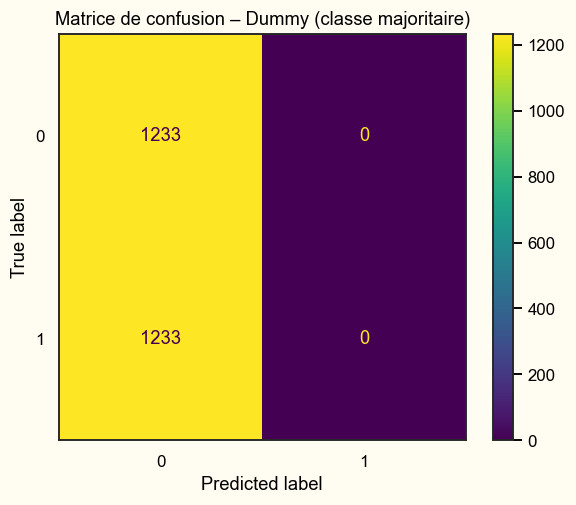


=== Comparaison finale (avec baseline) ===


,model,best_threshold,F1,Recall,Precision,ROC_AUC,best_params
1,RF_balanced,0.546895,0.89467,0.850770,0.943345,0.962071,"{'clf__max_depth': 10, 'clf__min_samples_leaf'..."
2,LogReg_balanced,0.477592,0.87980,0.854826,0.906277,0.937299,"{'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__s..."
0,Dummy_baseline,NaN,0.00000,0.000000,0.000000,0.500000,NaN


In [13]:
# === Comparaison avec un modèle Dummy (baseline) ===

print("\n=== Dummy Classifier (baseline) ===")

# Dummy qui prédit toujours la classe majoritaire
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_full, y_full)
y_pred_dummy = dummy.predict(X_full)

# Rapport de classification
print(classification_report(y_full, y_pred_dummy, digits=3))

# Matrice de confusion
cm_dummy = confusion_matrix(y_full, y_pred_dummy)
ConfusionMatrixDisplay(cm_dummy).plot()
plt.title("Matrice de confusion – Dummy (classe majoritaire)")
plt.show()

# Calcul des scores Dummy
dummy_f1 = f1_score(y_full, y_pred_dummy)
dummy_rec = recall_score(y_full, y_pred_dummy)
dummy_prec = precision_score(y_full, y_pred_dummy)
dummy_roc = roc_auc_score(y_full, y_pred_dummy)

# Comparaison synthétique
baseline_row = pd.DataFrame({
    'model': ['Dummy_baseline'],
    'best_threshold': [np.nan],
    'F1': [dummy_f1],
    'Recall': [dummy_rec],
    'Precision': [dummy_prec],
    'ROC_AUC': [dummy_roc]
})

res_df_final = pd.concat([baseline_row, res_df], ignore_index=True)
res_df_final = res_df_final.sort_values(by='F1', ascending=False)
print("\n=== Comparaison finale (avec baseline) ===")
display(res_df_final)

## 10) Interprétation : importance globale & locale (SHAP)

In [14]:
warnings.filterwarnings("ignore", category=UserWarning)

print("\n=== Interprétation du modèle : importances et valeurs SHAP ===")

# --- Sélection du meilleur modèle ---
if best_model_name == 'LogReg_balanced':
    best_model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)
else:
    best_model = RandomForestClassifier(
        n_estimators=400, class_weight='balanced_subsample', random_state=RANDOM_STATE
    )

# --- Pipeline final complet ---
final_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('prep', preproc2),
    ('clf', best_model)
])

# --- Entraînement global ---
final_pipe.fit(X_full, y_full)
fitted_model = final_pipe.named_steps['clf']


=== Interprétation du modèle : importances et valeurs SHAP ===



=== Interprétation SHAP globale ===
[INFO] 37 variables utilisées.
[INFO] X_transformed shape: (400, 37)


100%|===================| 797/800 [02:03<00:00]        

[INFO] SHAP array shape: (400, 37)


/Users/steph/Code/Python/Jupyter/projet_04/manet_projet04/shap_generator.py:90: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


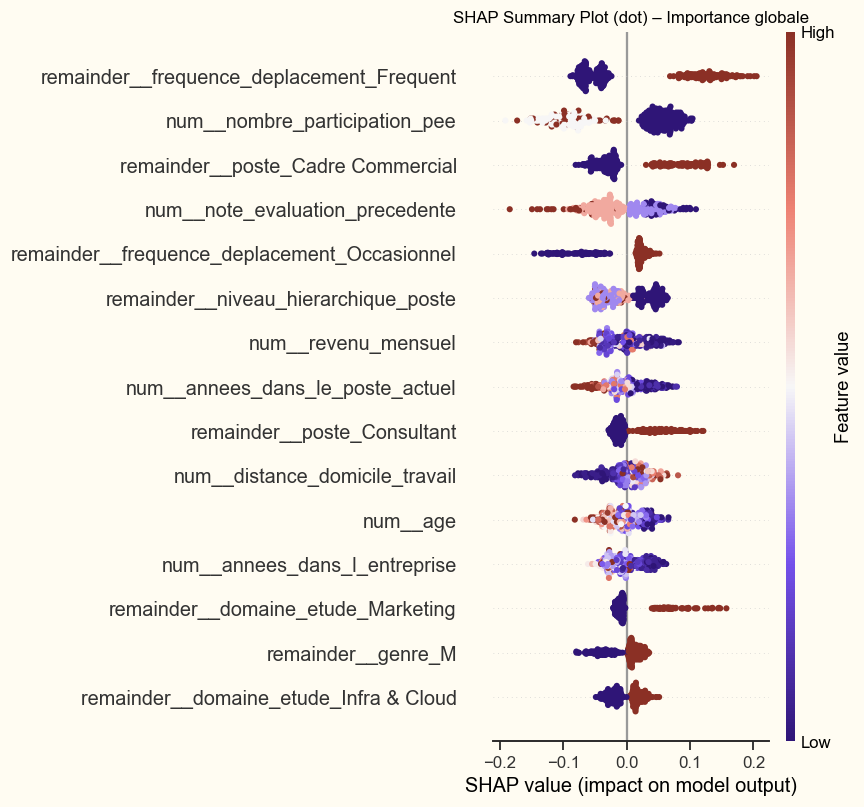

In [15]:
# === Calcul et affichage global ===
shap_values, X_transformed, feature_names = shap_global(final_pipe, X_full, y_full)


[INFO] Interprétation locale SHAP – individu 155


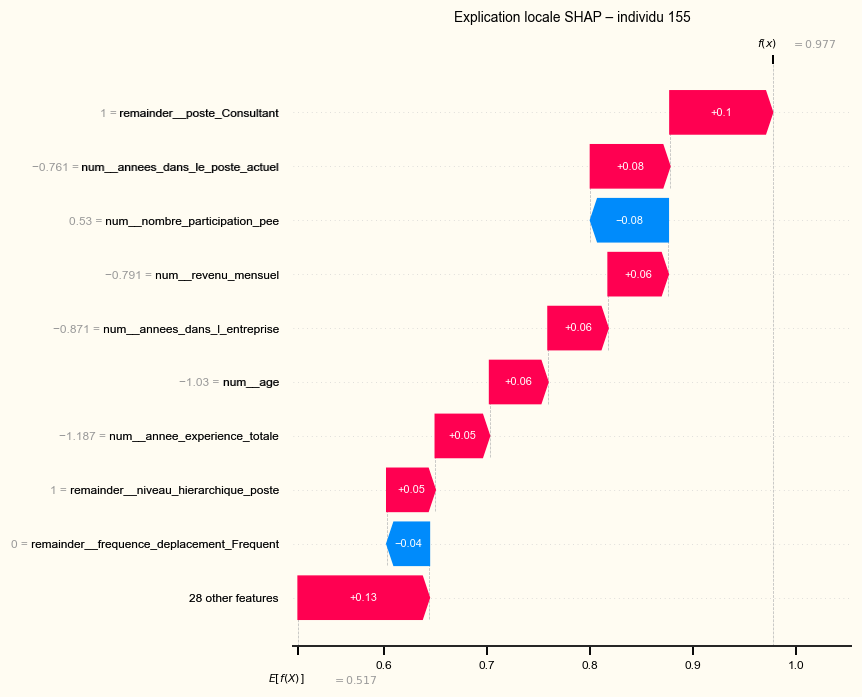


[INFO] Interprétation locale SHAP – individu 53


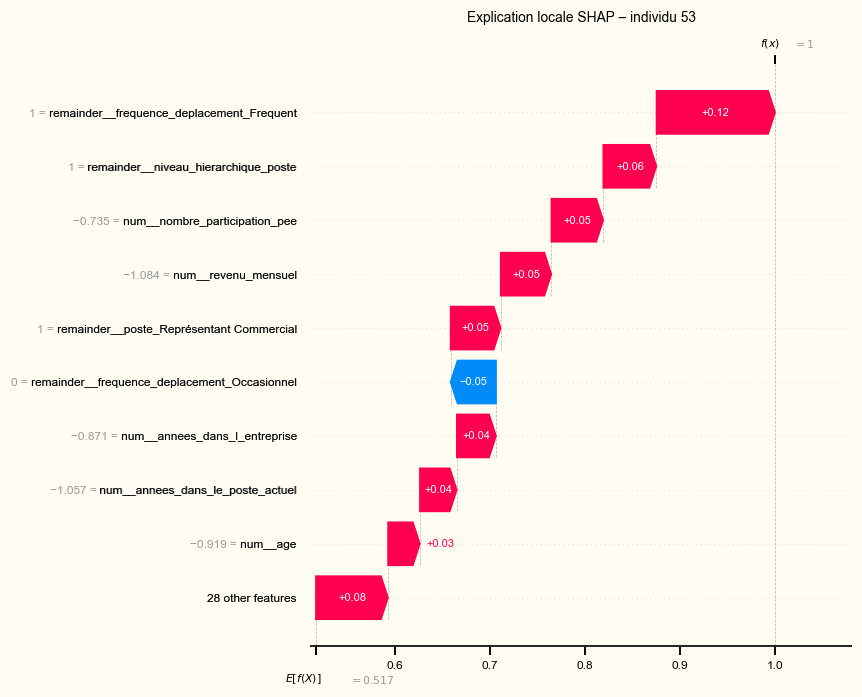


[INFO] Interprétation locale SHAP – individu 109


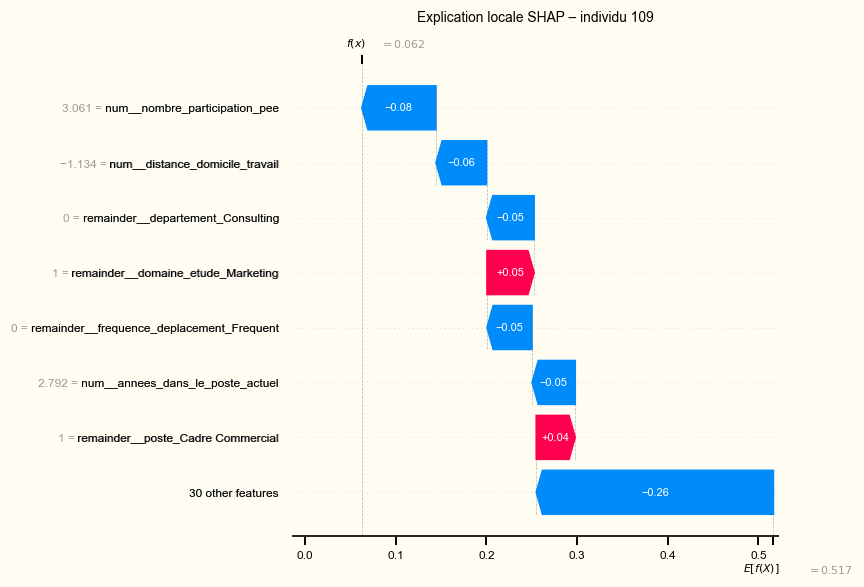


[INFO] Interprétation locale SHAP – individu 322


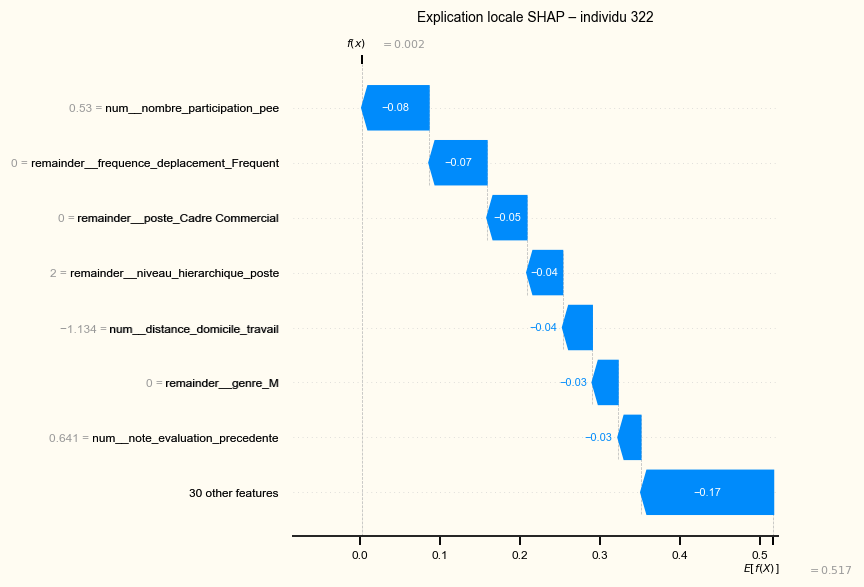

In [16]:
# Cas général : individu à plus fort impact
idx_impact = np.argmax(np.sum(np.abs(shap_values.values), axis=1))
shap_local(idx_impact, shap_values)

# Cas : individu à forte probabilité de départ
y_proba_all = final_pipe.named_steps['clf'].predict_proba(X_transformed)[:, 1]
idx_highrisk = int(np.argmax(y_proba_all))
shap_local(idx_highrisk, shap_values)

# Cas : individu choisi manuellement
CUSTOM_INDEX = 109
shap_local(CUSTOM_INDEX, shap_values, max_display=8)

# Cas : individu à plus faible probabilité de départ 
y_proba_all = final_pipe.named_steps['clf'].predict_proba(X_transformed)[:, 1]
idx_lowrisk = int(np.argmin(y_proba_all))
shap_local(idx_lowrisk, shap_values, max_display=8, text_scale=0.6)
